In [1]:
import glob

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [2]:
%matplotlib inline

In [3]:
# Find points for undistorting image
objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

calibration_images_paths = glob.glob('camera_cal/calibration*.jpg')
calibration_images = [cv2.imread(img_path) for img_path in calibration_images_paths]

for image in calibration_images:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(image, (9, 6), None)
    
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

In [4]:
# Helping functions
def undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (720, 1280), None, None)
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_img

# Transform image to bird-eye view
def warp(img):
    src = np.float32([[277,670],
                      [581,460],
                      [701,460],
                      [1025,670]])
    
    dst = np.float32([[277,720],
                      [277,0],
                      [1025,0],
                      [1025,720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
    
    return warped


# Transform image to normal view
def unwarp(img):
    src = np.float32([[277,670],
                      [581,460],
                      [701,460],
                      [1025,670]])
    
    dst = np.float32([[277,720],
                      [277,0],
                      [1025,0],
                      [1025,720]])
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(img, Minv, (img.shape[1],img.shape[0]))
    
    return unwarped

In [5]:
# Thresholds
def abs_sobel_thresh(channel, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        dx, dy = 1, 0
    elif orient == 'y':
        dx, dy = 0, 1
    
    sobel_dir = cv2.Sobel(channel, cv2.CV_64F, dx, dy, ksize=sobel_kernel)
    abs_sobel_dir = np.sqrt(sobel_dir**2)
    
    scaled_sobel_dir = (abs_sobel_dir * 255 / np.max(abs_sobel_dir)).astype(np.uint8)
    
    binary_dir = np.zeros_like(scaled_sobel_dir)
    binary_dir[(scaled_sobel_dir >= thresh[0]) & (scaled_sobel_dir <= thresh[1])] = 1
    return binary_dir

def mag_thresh(channel, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobel = np.sqrt(sobelx**2 + sobely**2)
    
    scaled_sobel = (abs_sobel * 255 / np.max(abs_sobel)).astype(np.uint8)
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_thresh(channel, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    grad_dir = np.arctan2(sobely, sobelx)
    
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return dir_binary

In [6]:
# Initial finding of lanes
def find_lane_edges(warped_binary, margin=100, nwindows=9, minpix=50):
    histogram = np.sum(warped_binary[np.int(warped_binary.shape[0]/2):,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    window_height = np.int(warped_binary.shape[0]/nwindows)

    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_idxs = []
    right_lane_idxs = []

    for window in range(nwindows):
        win_y_low = warped_binary.shape[0] - (window+1)*window_height
        win_y_high = warped_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        good_left_idxs = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_idxs = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_idxs.append(good_left_idxs)
        right_lane_idxs.append(good_right_idxs)

        if len(good_left_idxs) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_idxs]))

        if len(good_right_idxs) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_idxs]))

    left_lane_idxs = np.concatenate(left_lane_idxs)
    right_lane_idxs = np.concatenate(right_lane_idxs)

    leftx = nonzerox[left_lane_idxs]
    lefty = nonzeroy[left_lane_idxs]
    rightx = nonzerox[right_lane_idxs]
    righty = nonzeroy[right_lane_idxs]

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

In [7]:
# Updating of lane edges if lanes were found previously
def update_lane_edges(warped_binary, prev_left_fit, prev_right_fit, margin=100):
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_idxs = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + (prev_left_fit[1]*nonzeroy) + prev_left_fit[2] - margin)) &
                      (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + (prev_left_fit[1]*nonzeroy) + prev_left_fit[2] + margin)))

    right_lane_idxs = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + (prev_right_fit[1]*nonzeroy) + prev_right_fit[2] - margin)) &
                       (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + (prev_right_fit[1]*nonzeroy) + prev_right_fit[2] + margin)))

    leftx = nonzerox[left_lane_idxs]
    lefty = nonzeroy[left_lane_idxs]
    rightx = nonzerox[right_lane_idxs]
    righty = nonzeroy[right_lane_idxs]

    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit

In [8]:
# Return birds-eye view of lane on black background
def draw_warped_lane(warped_binary, left_fit, right_fit):
    bg_channel = np.zeros_like(warped_binary)
    bg_img = np.dstack((bg_channel, bg_channel, bg_channel))*255
    lane_img = np.zeros_like(bg_img)

    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    lane_left_edge = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    lane_right_edge = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_edges = np.hstack((lane_left_edge, lane_right_edge))

    cv2.fillPoly(lane_img, np.int_(lane_edges), (0,255,0))
    
    return lane_img

In [9]:
# Helping function that finds or updates lanes 
# and returns coefficients for both lane lines and arrays with last N fits
def find_next_fits(warped_binary, last_left_fits, last_right_fits):
    # If there are no arrays with last N fits, it create them
    # Currently it is used only in the beginning
    if ((last_left_fits is None) or (last_right_fits is None)):
        predicted_left_fit, predicted_right_fit = find_lane_edges(warped_binary)
        
        last_left_fits, last_right_fits = (list(np.tile(np.array([predicted_left_fit]),(smooth_depth,1))),
                                           list(np.tile(np.array([predicted_right_fit]),(smooth_depth,1))))
        
    # In all other cases I add new fits to the end of "memory arrays" and remove first ones
    else:
        predicted_left_fit, predicted_right_fit = update_lane_edges(warped_binary, last_left_fits[-1], last_right_fits[-1])
        del last_left_fits[0]
        del last_right_fits[0]
        
        last_left_fits.append(predicted_left_fit)
        last_right_fits.append(predicted_right_fit)
    
    # To make everything smooth I return an average of all fits, respectively for both sides
    smooth_left_fit = np.average(last_left_fits, axis=0)
    smooth_right_fit = np.average(last_right_fits, axis=0)
    
    return smooth_left_fit, smooth_right_fit, last_left_fits, last_right_fits

In [10]:
# Find curvature similarly to how it was found in class
def find_curvature(left_fit, right_fit):
    ploty = np.linspace(0, 719, 720)
    
    y_eval = 719
    
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return ((left_curverad + right_curverad) / 2).round(0)

In [11]:
# Find car position with respect to the center of the lane
def find_position(left_fit, right_fit):
    xm_per_pix = 3.7 / 700
    
    y = 719
    
    # Find coordinates of both lane markings
    leftlane_x = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    rightlane_x = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
    
    lane_center = (leftlane_x + rightlane_x) / 2
    
    position = (640  - lane_center) * xm_per_pix
    position_cm = position * 100
    
    return position_cm.round(0)

In [12]:
# Check new coefficients and accept only if they are close to previous fit, otherwise - use previous coefficients
def sanity_check_and_update(new_fit, previous_fit):
    low_ratio = 0.9
    high_ratio = 1.1
    
    if not ((low_ratio < previous_fit[0]/new_fit[0] < high_ratio) or
            (low_ratio < previous_fit[1]/new_fit[1] < high_ratio) or
            (low_ratio < previous_fit[2]/new_fit[2] < high_ratio)):
        fit = previous_fit
    else:
        fit = new_fit
    
    return fit

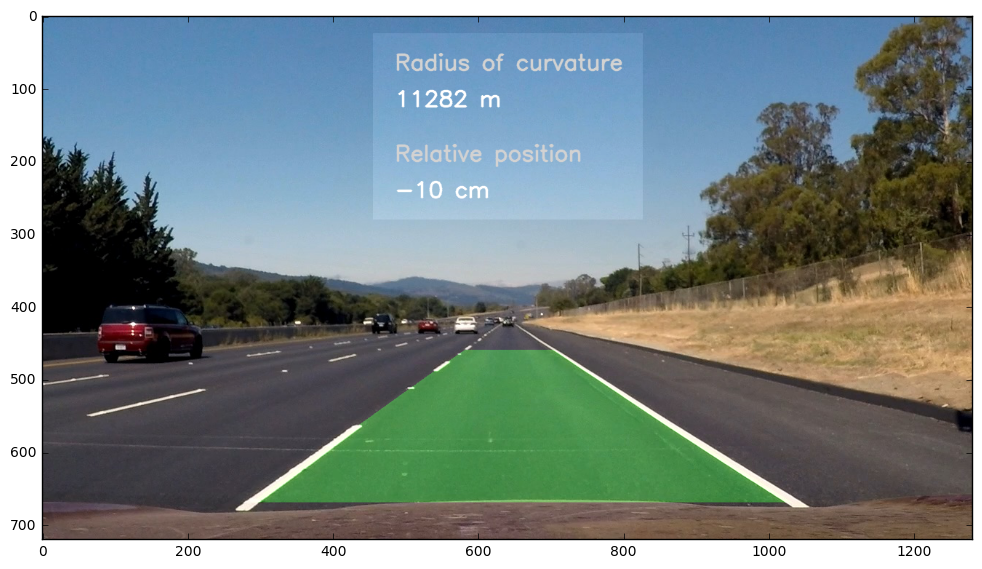

In [13]:
### PIPELINE

# Number of frames to smooth
smooth_depth = 3

# Initialization of arrays for last N fits
last_left_fits, last_right_fits = None, None

# Font for curvature and car position message
font = cv2.FONT_HERSHEY_SIMPLEX

def process_image(img):
    global last_left_fits
    global last_right_fits
    
    output_img = np.copy(img)

    # Undistort image
    undistorted_img = undistort(img, objpoints, imgpoints)
    
    # S channel provides keeps a lot of useful information for purposes of this project
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h, l, s = cv2.split(hls_img)

    # Applying thresholds
    sobel_kernel = 15
    thresholds = (50, 255)
    thresholds_dir = (0.7, 1.2)

    l_dir = dir_thresh(l, sobel_kernel, thresholds_dir)           # Directional threshold on L channel
    l_mag = mag_thresh(l, sobel_kernel, thresholds)               # Gradient magnitude threshold on L channel 
    s_mag = mag_thresh(s, sobel_kernel, thresholds)               # Gradient magnitude threshold on S channel
    l_abs_x = abs_sobel_thresh(l, 'x', sobel_kernel, thresholds)  # Magnitude threshold in X direction on L channel
    s_abs_x = abs_sobel_thresh(s, 'x', sobel_kernel, thresholds)  # Magnitude threshold in X direction on S channel

    binary = np.zeros_like(img[:,:,0])
    binary[((s_mag != 0) | (l_mag != 0)) & ((s_abs_x != 0) | (l_abs_x !=0) | (l_dir != 0))] = 1

    # Warp binary image
    warped_binary = warp(binary)

    # Find candidates for current fits and update arrays that keep last N fits
    left_fit, right_fit, last_left_fits, last_right_fits = find_next_fits(warped_binary, last_left_fits, last_right_fits)
    
    # Check that new fits are close to previous ones
    left_fit = sanity_check_and_update(left_fit, last_left_fits[-1])
    right_fit = sanity_check_and_update(right_fit, last_right_fits[-1])
    
    # Find curvature of the lane in meters and position of the car relative to the center of the lane in centimeters
    curvature = find_curvature(left_fit, right_fit)
    position = find_position(left_fit, right_fit)
    
    # Draw lane on the black background to merge
    warped_lane = draw_warped_lane(warped_binary, left_fit, right_fit)
    
    # Change perspective of the lane image to normal
    unwarped_lane = unwarp(warped_lane)

    # Merge unwarped lane with original image
    result = cv2.addWeighted(output_img, 1, unwarped_lane, 0.3, 0)
    
    # Add some text and text box
    text_background = np.zeros_like(img)
    cv2.rectangle(text_background,(455,25), (825,280), (15,15,15), -1)
    
    result = cv2.addWeighted(result, 1, text_background, 0.9, 0)

    cv2.putText(result, str('Radius of curvature'), (485,75), font, 1, (210, 210, 210), 2, cv2.LINE_AA)
    cv2.putText(result, str(str(int(curvature)) + ' m'), (485,125), font, 1, (255,255,255), 2, cv2.LINE_AA)

    cv2.putText(result, str('Relative position'), (485,200), font, 1, (210,210,210), 2, cv2.LINE_AA)
    cv2.putText(result, str(str(int(position)) + ' cm'), (485,250), font, 1, (255,255,255), 2, cv2.LINE_AA)
    
    return result
    
img = mpimg.imread('test_images/straight_lines2.jpg')

processed_img = process_image(img)

plt.figure(figsize=(12,12))
plt.imshow(processed_img);

In [ ]:
# from moviepy.editor import VideoFileClip

# output = 'short_output.mp4'
# clip = VideoFileClip('short.mp4')
# processed_clip = clip.fl_image(process_image)
# %time processed_clip.write_videofile(output, audio=False)

In [ ]:
from moviepy.editor import VideoFileClip

output = 'processed_project_video.mp4'
clip = VideoFileClip('project_video.mp4')
processed_clip = clip.fl_image(process_image)
%time processed_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video processed_project_video.mp4
[MoviePy] Writing video processed_project_video.mp4


  7%|▋         | 92/1261 [02:52<36:08,  1.86s/it]